*Base*

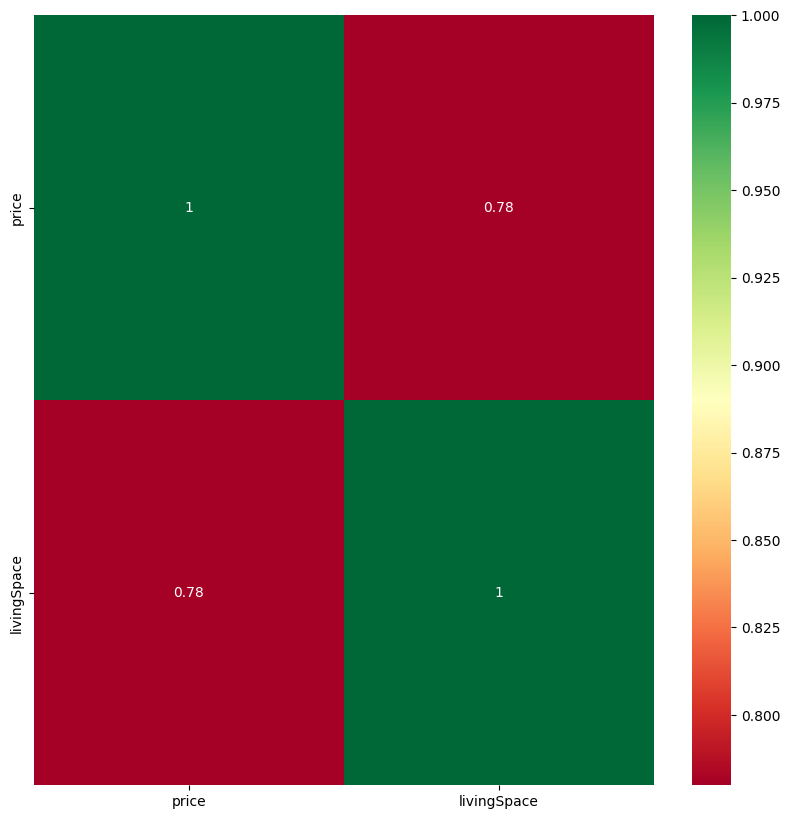

In [19]:
# Import necessary libraries
import mysql.connector
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import matplotlib.pyplot as plt
# from sklearn.model_selection import GridSearchCV

# Define your input features and output feature
input_features = ['latitude', 'longitude', 'livingSpace', 'rooms', 'floor']
output_feature = 'price'

# Create a connection to the database
db = mysql.connector.connect(
    host="localhost",
    user="user",
    password="password",
    port="3306",
    database="realestatepredictor"
)

# Create a cursor object
cursor = db.cursor()

# Execute a query to fetch all data from the 'homegate' table
cursor.execute("SELECT * FROM homegate")

# Fetch all rows from the last executed statement using fetchall() method
data = cursor.fetchall()

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data, columns=['id','homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])

# Handle null or empty values
df = df.dropna()

# Remove outliers, lower pricing
df = df[df[output_feature] > 500000]

# Prepare the data for the model
X = df[input_features]  # Features
y = df[output_feature]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Calculate the correlation matrix for numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

# Identify highly correlated features
highly_corr_features = corr.index[abs(corr[output_feature])>0.5]

# Create a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df[highly_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()

**Nearest Neightbor**

Mean Squared Error: 613681202945.4546


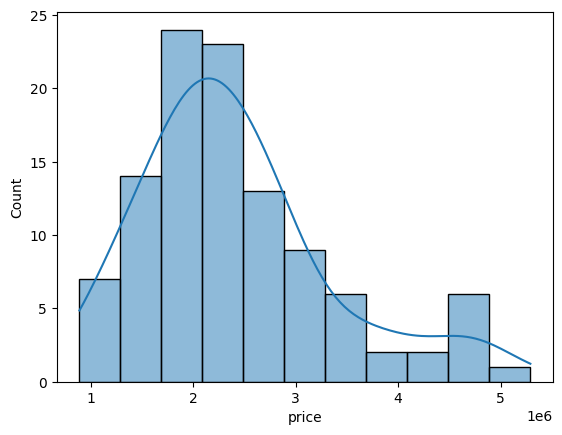

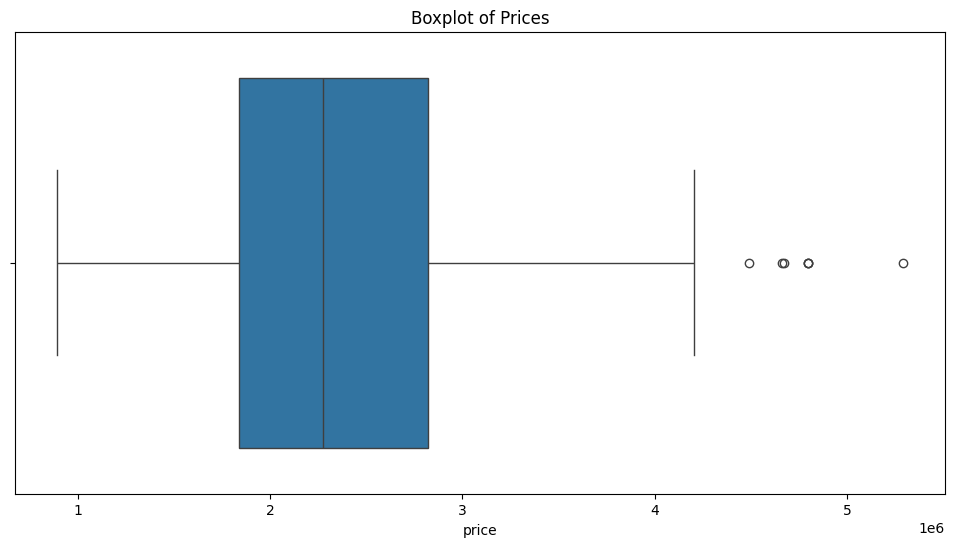

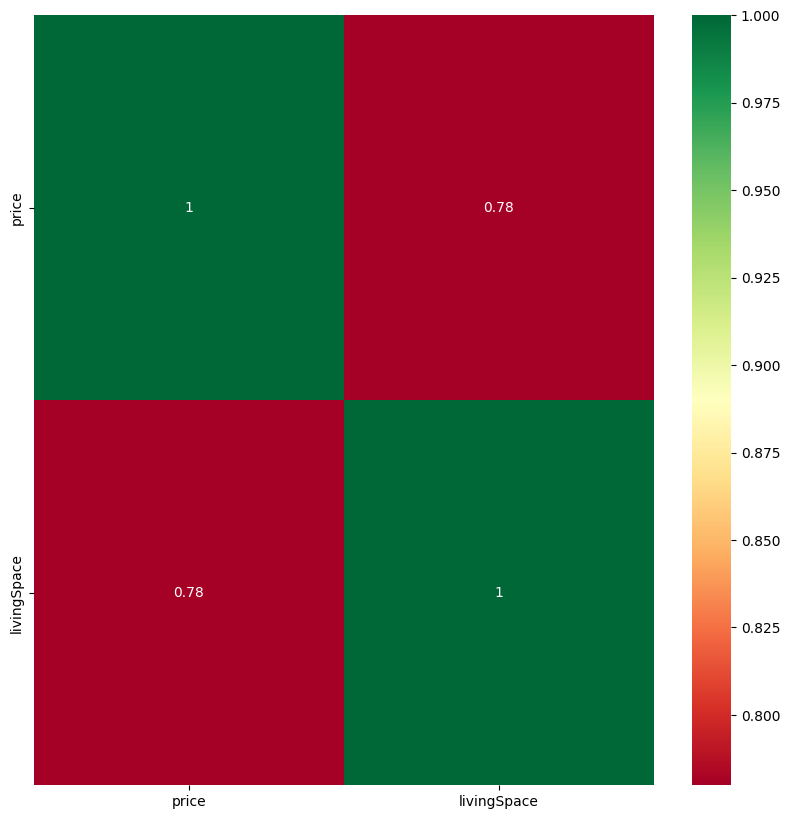

In [20]:
# Create a KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)

# Train the model using the training sets
knn.fit(X_train, y_train)

# Predict the prices for the test set
y_pred = knn.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

sns.histplot(df['price'], kde=True)
# Create a boxplot for the prices
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Prices')
plt.show()

# Calculate the correlation matrix for numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

# Identify highly correlated features
highly_corr_features = corr.index[abs(corr[output_feature])>0.5]

# Create a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df[highly_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()

**Random Forest**

Mean Squared Error: 613681202945.4546


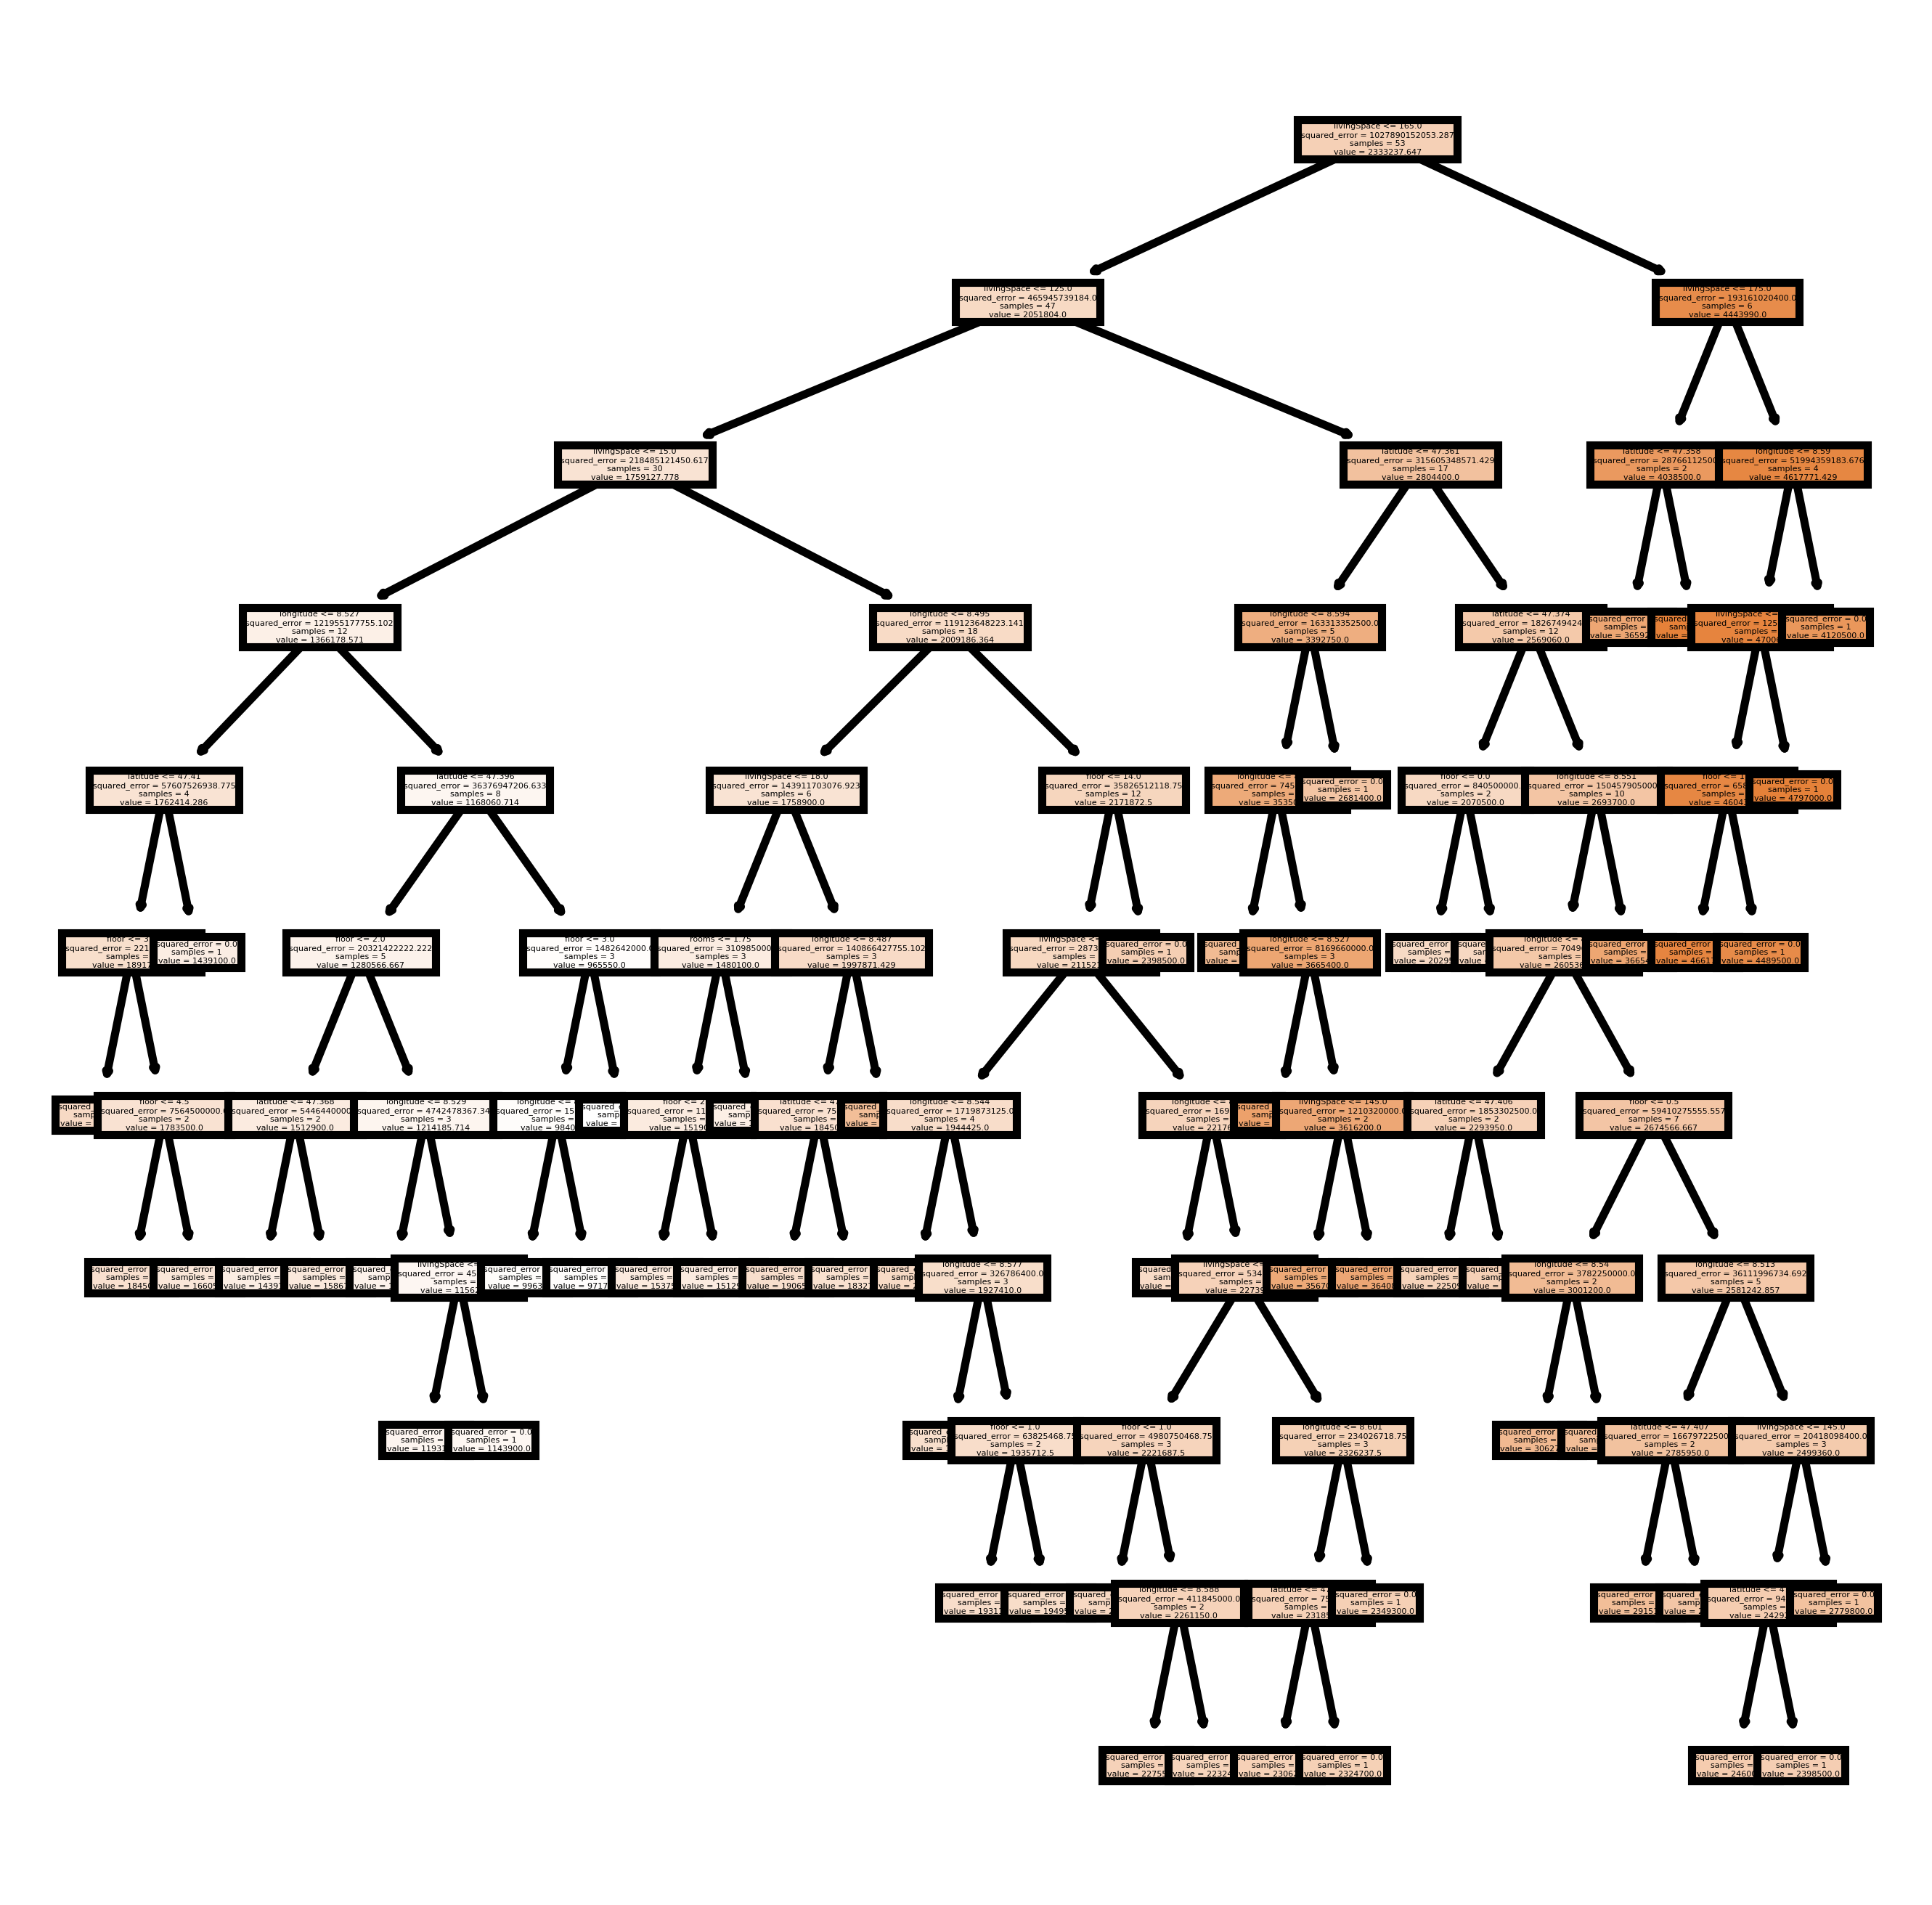

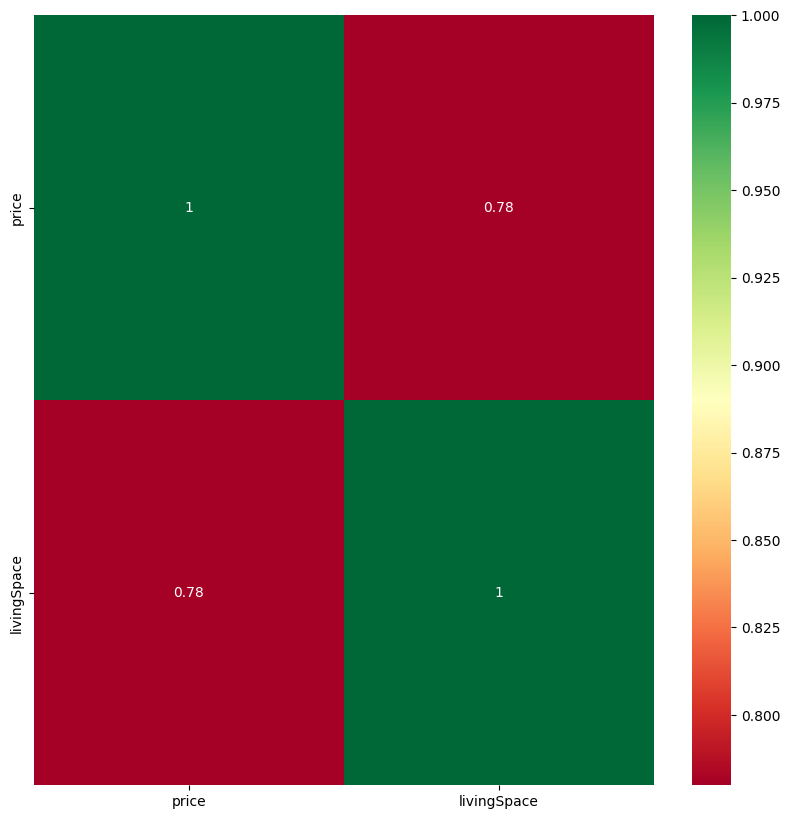

In [21]:
# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=1)

# Train the model using the training sets
rf.fit(X_train, y_train)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Visualize one decision tree from the forest
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names=X.columns,
               class_names=[str(y.name)],
               filled=True)
fig.savefig('rf_individualtree.png')

# Calculate the correlation matrix for numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

# Identify highly correlated features
highly_corr_features = corr.index[abs(corr[output_feature])>0.5]

# Create a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df[highly_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()


**Hyperparameters**

In [22]:
from sklearn.model_selection import GridSearchCV

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN regressor
knn = KNeighborsRegressor()

# Define the grid of hyperparameters to search
grid = {'n_neighbors': range(1, 10)}

# Use GridSearchCV to find the optimal number of neighbors
knn_cv = GridSearchCV(knn, grid, cv=5, scoring='neg_mean_squared_error')
knn_cv.fit(X_train_scaled, y_train)

# Train the model using the training sets with the best found number of neighbors
knn_best = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn_best.fit(X_train_scaled, y_train)

# Predict the prices for the test set
y_pred = knn_best.predict(X_test_scaled)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"KNN Mean Squared Error: {mse}")

# Create a Random Forest regressor
rf = RandomForestRegressor(random_state=1)

# Define the grid of hyperparameters to search
grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}

# Use GridSearchCV to find the optimal hyperparameters
rf_cv = GridSearchCV(rf, grid, cv=5, scoring='neg_mean_squared_error')
rf_cv.fit(X_train_scaled, y_train)

# Train the model using the training sets with the best found hyperparameters
rf_best = RandomForestRegressor(n_estimators=rf_cv.best_params_['n_estimators'], max_depth=rf_cv.best_params_['max_depth'], random_state=1)
rf_best.fit(X_train_scaled, y_train)

# Predict the prices for the test set
y_pred = rf_best.predict(X_test_scaled)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest Mean Squared Error: {mse}")

KNN Mean Squared Error: 401735802200.0
Random Forest Mean Squared Error: 407627101841.70624
